# POC RSM

Try to apply RubberSheetModel from *daugman* to a ellipse.

## Standard RSM

Input image


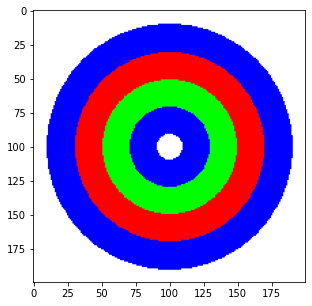

In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5,5)

image_size = 200
circle = np.zeros((image_size,image_size,3), np.uint8)
circle.fill(255)

colors = [(255,0,0), (0,255,0), (0,0,255)]
inner_radius = 20
outer_radius = 100
thickness = 20

for radius in range(inner_radius, outer_radius, 20):
    circle = cv2.circle(circle, (int(image_size/2), int(image_size/2)), radius, colors[radius % len(colors)], thickness)

print('Input image')
plt.imshow(circle)

Result


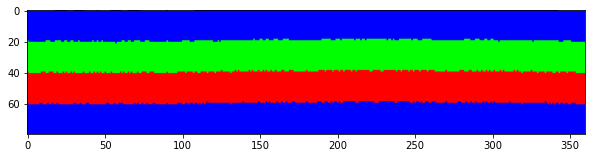

In [2]:
plt.rcParams["figure.figsize"] = (10,10)

def daugman_normalization(image, iris_radius, samples, inner_radius, outer_radius):
  """Implementation of ruber-sheet model by daugman (adapted from: https://github.com/YifengChen94/IrisReco)

  Args:
      image (np.array): the input image
      iris_radius (int): radius of iris (see paper) (y-Ax_is of the rectangular polar form)
      samples (int): number of samples per 360° (x-Axis of rectangular polar form)
      inner_radius (int): radius of inner circle (pupil)
      outer_radius (int): radius of outer circle (boarder of iris)

  Returns:
      np.array: rectangular polar form of the provided image
  """
  # Theta values for 360 degrees - 2 Pi
  thetas = np.arange(0, 2 * np.pi, 2 * np.pi / samples)  
  # Create empty flatten image - rectangular region in polar coordinates
  polarForm = np.zeros((iris_radius, samples, 3), np.uint8)
  # Assume center is in the middle
  center_x = int(image.shape[0] / 2)
  center_y = int(image.shape[1] / 2)

  # create 
  for i in range(samples):
      # x of polarform
      theta = thetas[i]   # value of theta 

      # get coordinate of boundaries of Cartesian input
      Xi = center_x + inner_radius * np.cos(theta)
      Yi = center_y + inner_radius * np.sin(theta)
      Xo = center_x + outer_radius * np.cos(theta)
      Yo = center_y + outer_radius * np.sin(theta)

      for r in range(iris_radius):
        # y of polarform
        r_pro = r / iris_radius  # r normalized [0,1]

        # the matched Cartesian coordinates for the polar coordinates
        Xc = (1 - r_pro) * Xi + r_pro * Xo
        Yc = (1 - r_pro) * Yi + r_pro * Yo

        pixel = image[int(Xc)][int(Yc)]  # get Cartesian pixel
        polarForm[r][i] = pixel
  return polarForm 

result0 = daugman_normalization(circle, outer_radius - inner_radius, 360, inner_radius - thickness/2, outer_radius - thickness/2)

print('Result')
plt.imshow(result0)

## Apply RSM To Ellipse

Some tries ...

Input image (Ellipse)


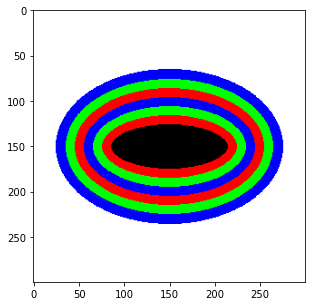

In [3]:
plt.rcParams["figure.figsize"] = (5,5)

image_size = 300
ellipse = np.zeros((image_size,image_size,3), np.uint8)
ellipse.fill(255)

colors = [(255,0,0), (0,255,0), (0,0,255)]
thickness = 10
center = int(image_size/2)

inner_axes_x = 70
inner_axes_y = 30
ellipse_thickness = 60

ellipse = cv2.ellipse(ellipse, (center, center), (inner_axes_x-1, inner_axes_y-1), 0, 0, 360, (0,0,0), thickness=-1)

for step in range(0, ellipse_thickness, thickness):
    axes_x = inner_axes_x + step
    axes_y = inner_axes_y + step
    # image, centerPoint, axes lengths, angle, startangle, endangle, color, thickness
    ellipse = cv2.ellipse(ellipse, (center, center), (axes_x, axes_y), 0, 0, 360, colors[step % len(colors)], thickness)

print('Input image (Ellipse)')
plt.imshow(ellipse)

## First try (intuitive approach)

Result 1


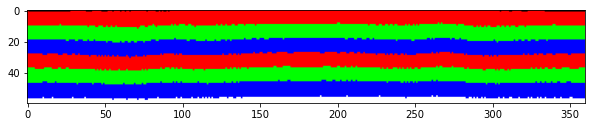

In [4]:
plt.rcParams["figure.figsize"] = (10,10)


def polar_r_ellipse(a, b, theta):
    """get r from ellipse

    Args:
        a (int): a axis
        b (int): b axis
        theta (float): theta in rad

    Returns:
        float: the calculated r
    """
    numerator =  a*b
    denominator = math.sqrt(math.pow(a * math.sin(theta),2) + math.pow(b * math.cos(theta), 2))
    return numerator/denominator


def daugman_normalization_adapted(image, ellipse_thickness, samples, inner_axis, outer_axis):
  """Implementation of ruber-sheet model by daugman for ellipses

  Args:
      image (np.array): the input image
      ellipse_thickness (int): thickness of the band (like radius of iris (see paper) (y-Axis of the rectangular polar form))
      samples (int): number of samples per 360° (x-Axis of rectangular polar form)
      inner_axis (int, int): inner axis (x,y)
      outer_axis (int, int): outer axis (x,y)

  Returns:
      np.array: rectangular polar form of the provided image
  """
  # Theta values for 360 degrees - 2 Pi
  thetas = np.arange(0, 2 * np.pi, 2 * np.pi / samples)  
  # Create empty flatten image - rectangular region in polar coordinates
  polarForm = np.zeros((ellipse_thickness, samples, 3), np.uint8)
  # Assume center is in the middle
  center_x = int(image.shape[0] / 2)
  center_y = int(image.shape[1] / 2)

  # create 
  for sample in range(samples):
    # x of polarfrom
    theta = thetas[sample]   # value of theta 

    # Additional step calculate r from axis and theta
    a = inner_axis[1]
    b = inner_axis[0] 
    inner_radius = polar_r_ellipse(a,b, theta)
    a = outer_axis[1]
    b = outer_axis[0]
    outer_radius = polar_r_ellipse(a,b, theta)

    # get coordinate of boundaries of Cartesian input
    Xi = center_x + inner_radius * np.cos(theta)
    Yi = center_y + inner_radius * np.sin(theta)
    Xo = center_x + outer_radius * np.cos(theta)
    Yo = center_y + outer_radius * np.sin(theta)

    for r in range(ellipse_thickness): 
        # y of polarform
        r_pro = r / ellipse_thickness  # r normalized [0,1]

        # the matched Cartesian coordinates for the polar coordinates
        # its not a radius cause its an ellipse
        Xc = (1 - r_pro) * Xi + r_pro * Xo
        Yc = (1 - r_pro) * Yi + r_pro * Yo
        pixel = image[int(Xc)][int(Yc)]  # get Cartesian pixel
        polarForm[r][sample] = pixel
  return polarForm 

inner_axes = (inner_axes_x - thickness / 2, inner_axes_y - thickness / 2)
outer_axes = (inner_axes_x + ellipse_thickness, inner_axes_y + ellipse_thickness)

result = daugman_normalization_adapted(ellipse, ellipse_thickness, 360, inner_axes, outer_axes)

print('Result 1')
plt.imshow(result)

## RESULT NOT GOOD ENOUGH 

## Try 2 (Find point on Ellipse)

Result 2


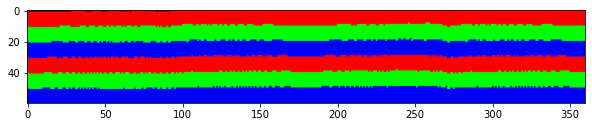

In [5]:
plt.rcParams["figure.figsize"] = (10,10)


def get_point_on_ellipse(a, b, theta):
    """get point on ellipse for theta from center

    Args:
        a (int): a axis
        b (int): b axis
        theta (float): theta in rad

    Returns:
        (float, float): the calculated point
    """
    x = (a*b)/(math.sqrt(math.pow(b,2) + math.pow(a,2)*math.pow(math.tan(theta),2)))
    
    if not (- math.pi/2 < theta < math.pi/2):
        x = -x
    y = x * math.tan(theta)
    return (x, y)


def daugman_normalization_adapted_2(image, ellipse_thickness, samples, axes):
  """Implementation of ruber-sheet model by daugman for ellipses

  Args:
      image (np.array): the input image
      ellipse_thickness (int): thickness of the band (like radius of iris (see paper) (y-Axis of the rectangular polar form))
      samples (int): number of samples per 360° (x-Axis of rectangular polar form)
      axes (int, int): inner axis (x,y)

  Returns:
      np.array: rectangular polar form of the provided image
  """
  # Theta values for 360 degrees - 2 Pi
  thetas = np.arange(0, 2 * np.pi, 2 * np.pi / samples)  
  # Create empty flatten image - rectangular region in polar coordinates
  polarForm = np.zeros((ellipse_thickness, samples, 3), np.uint8)
  # Assume center is in the middle
  center_x = int(image.shape[0] / 2)
  center_y = int(image.shape[1] / 2)

  for r in range(ellipse_thickness):
    # increase axis lengths  
    a = axes[1] + r
    b = axes[0] + r  
    # create 
    for sample in range(samples):
        # x of polarfrom
        theta = thetas[sample]   # value of theta 
        x_offset , y_offset = get_point_on_ellipse(a,b, theta)
        x = center_x + x_offset
        y = center_y + y_offset
        pixel = image[int(x)][int(y)]  # get Cartesian pixel
        polarForm[r][sample] = pixel
  return polarForm 


inner_axes = (inner_axes_x - thickness/2, inner_axes_y - thickness/2)

result2 = daugman_normalization_adapted_2(ellipse, ellipse_thickness, 360, inner_axes)

print('Result 2')
plt.imshow(result2)

## JUST WORKING ON QUADRANT 1 and 2 of Circle + Problems with theta 90 and 270

## Try 3 - Polar form relative to center

Result 3


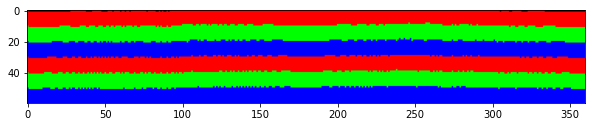

In [6]:
plt.rcParams["figure.figsize"] = (10,10)


def polar_r_ellipse(a, b, theta):
    """get r from ellipse
    see: https://en.wikipedia.org/wiki/Ellipse#Polar_form_relative_to_center
    Args:
        a (int): a axis
        b (int): b axis
        theta (float): theta in rad

    Returns:
        float: the calculated r
    """
    numerator =  a*b
    denominator = math.sqrt(math.pow(a * math.sin(theta),2) + math.pow(b * math.cos(theta), 2))
    return numerator/denominator


def get_x_y(radius, theta):
    x = math.cos(theta) * radius
    y = math.sin(theta) * radius
    return (x, y)


def daugman_normalization_adapted_3(image, ellipse_thickness, samples, axes):
  """Implementation of ruber-sheet model by daugman for ellipses

  Args:
      image (np.array): the input image
      ellipse_thickness (int): thickness of the band (like radius of iris (see paper) (y-Axis of the rectangular polar form))
      samples (int): number of samples per 360° (x-Axis of rectangular polar form)
      axes (int, int): inner axis (x,y)

  Returns:
      np.array: rectangular polar form of the provided image
  """
  # Theta values for 360 degrees - 2 Pi
  thetas = np.arange(0, 2 * np.pi, 2 * np.pi / samples)  
  # Create empty flatten image - rectangular region in polar coordinates
  polarForm = np.zeros((ellipse_thickness, samples, 3), np.uint8)
  # Assume center is in the middle
  center_x = int(image.shape[0] / 2)
  center_y = int(image.shape[1] / 2)

  for r in range(ellipse_thickness):
    # increase axis lengths  
    a = axes[1] + r
    b = axes[0] + r  
    # create 
    for sample in range(samples):
        # x of polarfrom
        theta = thetas[sample]   # value of theta 

        # Additional step calculate r from axis and theta
        radius = polar_r_ellipse(a,b, theta)
        x_offset , y_offset = get_x_y(radius, theta)

        x = center_x + x_offset 
        y = center_y + y_offset
        pixel = image[int(x)][int(y)]  # get Cartesian pixel
        polarForm[r][sample] = pixel
  return polarForm 


inner_axes = (inner_axes_x - thickness/2, inner_axes_y - thickness/2)

result3 = daugman_normalization_adapted_3(ellipse, ellipse_thickness, 360, inner_axes)

print('Result 3')
plt.imshow(result3)

# WORKING ON THE FULL 360°

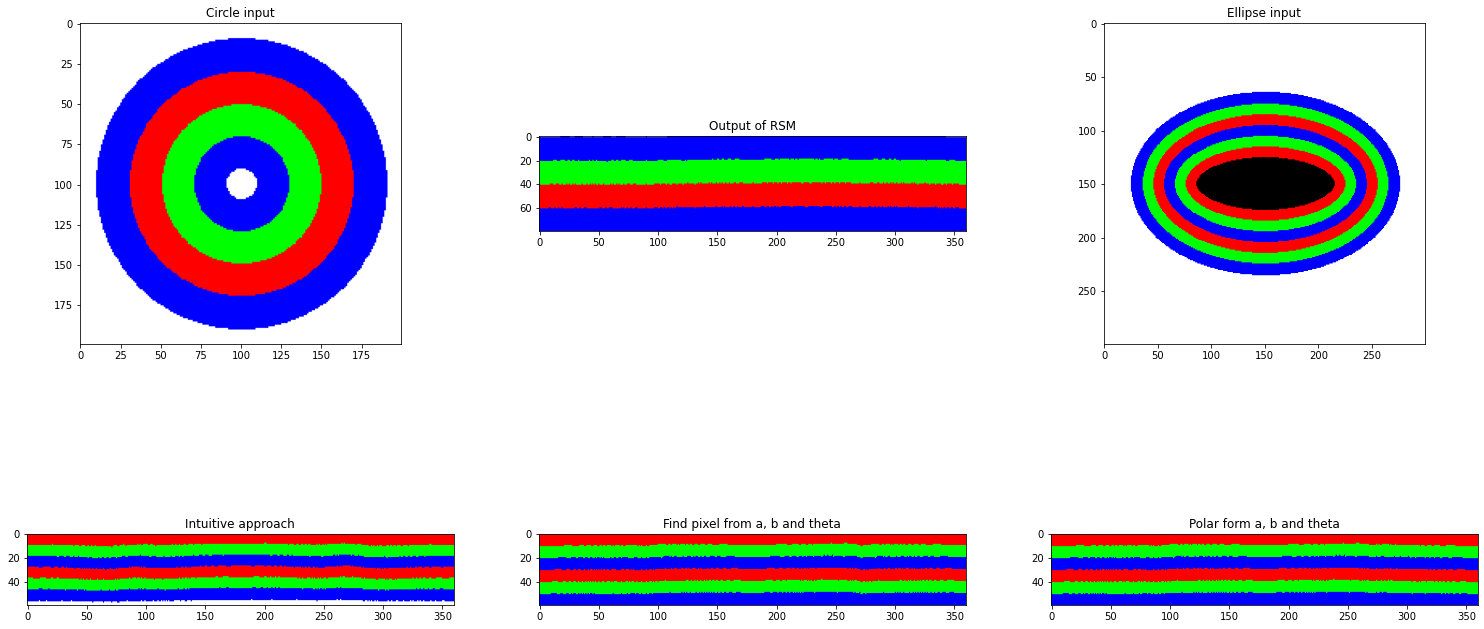

In [7]:
plt.rcParams["figure.figsize"] = (26,13)

_, axis = plt.subplots(2,3) 
axis[0][0].set_title('Circle input')
axis[0][0].imshow(circle)
axis[0][1].set_title('Output of RSM')
axis[0][1].imshow(result0)
axis[0][2].set_title('Ellipse input')
axis[0][2].imshow(ellipse)
axis[1][0].set_title('Intuitive approach')
axis[1][0].imshow(result)
axis[1][1].set_title('Find pixel from a, b and theta')
axis[1][1].imshow(result2)
axis[1][2].set_title('Polar form a, b and theta')
axis[1][2].imshow(result3)

# RSM on ellipse with angle

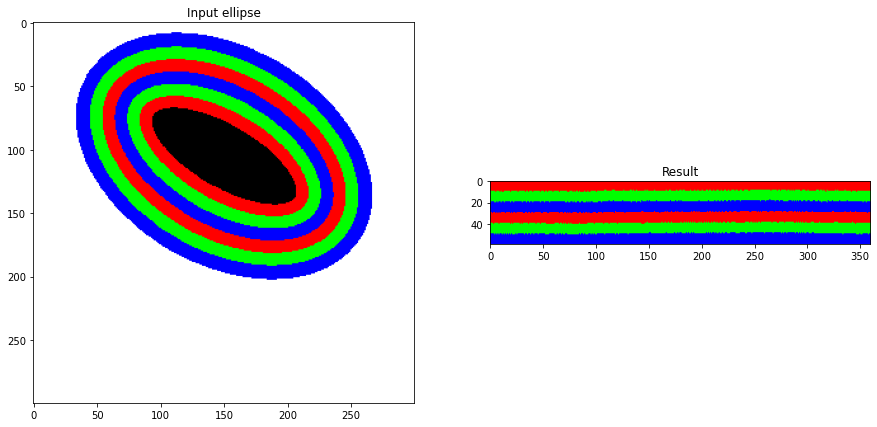

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (15,15)


def get_x_y_from_polar_r(radius, theta):
    x = math.cos(theta) * radius
    y = math.sin(theta) * radius
    return (x, y)


def daugman_normalization_ellipse(image, from_theta, to_theta, center, inner_axis, rotation, ellipse_thickness, samples):
    if from_theta >= to_theta:
        print('Failure from_theta bigger than to_theta')
        return None

    # Theta values for theta range 
    thetas = np.arange(from_theta, to_theta, abs(to_theta - from_theta) / samples)  
    # Create empty flatten image - rectangular region in polar coordinates
    polarForm = np.zeros((ellipse_thickness, samples, 3), np.uint8)


    for r in range(ellipse_thickness):
        # increase axis lengths  
        a = inner_axis[1] + r
        b = inner_axis[0] + r  
        # create 
        for sample in range(samples):
            # x of polarfrom
            theta = thetas[sample]   # value of theta 

            # Additional step calculate r from axis and theta
            radius = polar_r_ellipse(a,b, theta)
            x_offset , y_offset = get_x_y_from_polar_r(radius, theta)

            # adapt to rotation - with inplace rotation matrix
            xr = (x_offset * math.cos(-rotation)) - (y_offset * math.sin(-rotation))
            yr = (x_offset * math.sin(-rotation)) + (y_offset * math.cos(-rotation))

            x = center[1] + xr
            y = center[0] + yr

            pixel = image[int(x)][int(y)]  # get Cartesian pixel
            polarForm[r][sample] = pixel
    return polarForm 


image_size = 300
ellipse_rotated = np.zeros((image_size,image_size,3), np.uint8)
ellipse_rotated.fill(255)

colors = [(255,0,0), (0,255,0), (0,0,255)]
thickness = 10
center_x = int(image_size/2)
center_y = center_x - 45

inner_axes_x = 70
inner_axes_y = 30
ellipse_thickness = 60
ellipse_rotation = 30

ellipse_rotated = cv2.ellipse(ellipse_rotated, (center_x, center_y), (inner_axes_x-1, inner_axes_y-1), ellipse_rotation, 0, 360, (0,0,0), thickness=-1)

for step in range(0, ellipse_thickness, thickness):
    axes_x = inner_axes_x + step
    axes_y = inner_axes_y + step
    # image, centerPoint, axes lengths, angle, startangle, endangle, color, thickness
    ellipse_rotated = cv2.ellipse(ellipse_rotated, (center_x, center_y), (axes_x, axes_y), ellipse_rotation, 0, 360, colors[step % len(colors)], thickness)

inner_axes = (inner_axes_x - thickness/2, inner_axes_y - thickness/2)

result = daugman_normalization_ellipse(ellipse_rotated, 0, 2* np.pi, (center_x, center_y), inner_axes, np.deg2rad(ellipse_rotation), ellipse_thickness, 360)

_, axis = plt.subplots(1,2) 
axis[0].set_title('Input ellipse')
axis[0].imshow(ellipse_rotated)
axis[1].set_title('Result')
axis[1].imshow(result)